# Analysis of the Volatility of Bitcoin

## Setup

In [1]:
from adjustText import adjust_text
import matplotlib.colorbar as mpl_cbar
import matplotlib.colors as mpl_cols
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal

In [2]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

In [3]:
# Get all dfs
def get_df(csv_basename: str) -> pd.DataFrame:
    # Get df from CSV with date as index
    return pd.read_csv(f"../data/{csv_basename}.csv", index_col="date", parse_dates=True)

df_btc = get_df("BTC")
df_sp500 = get_df("SP500")
df_us10y = get_df("US10Y")
df_au = get_df("AU")
df_wti = get_df("WTI")
df_chf = get_df("CHF")

## Bitcoin Volatility Over Time 🎢

In [4]:
# Get log price change
df_btc["price_change_log"] = np.log(df_btc["price"] / df_btc["price"].shift(1))

In [5]:
# Biggest price changes
df_btc.loc[df_btc["price_change_log"].abs().sort_values(ascending=False).head(10).index, ["price_change_log"]].T

date,2010-07-18,2011-06-11,2010-07-22,2011-05-10,2010-11-06,2011-08-06,2012-08-19,2010-11-08,2013-04-10,2011-10-17
price_change_log,0.539996,-0.49144,-0.450003,0.42458,0.405465,-0.402907,-0.372425,-0.335884,-0.332134,-0.32891


In [6]:
# Get 90-day and 1-year volatility with the exponentially weighted moving average (EWMA) method
df_btc["volatility_90d"] = df_btc["price_change_log"].ewm(span=90).std()
df_btc["volatility_1y"] = df_btc["price_change_log"].ewm(span=365).std()

In [7]:
# Change first cycle values to NaN to avoid having unreliable volatility measures
df_btc.loc[:df_btc.index[89], "volatility_90d"] = np.nan
df_btc.loc[:df_btc.index[364], "volatility_1y"] = np.nan

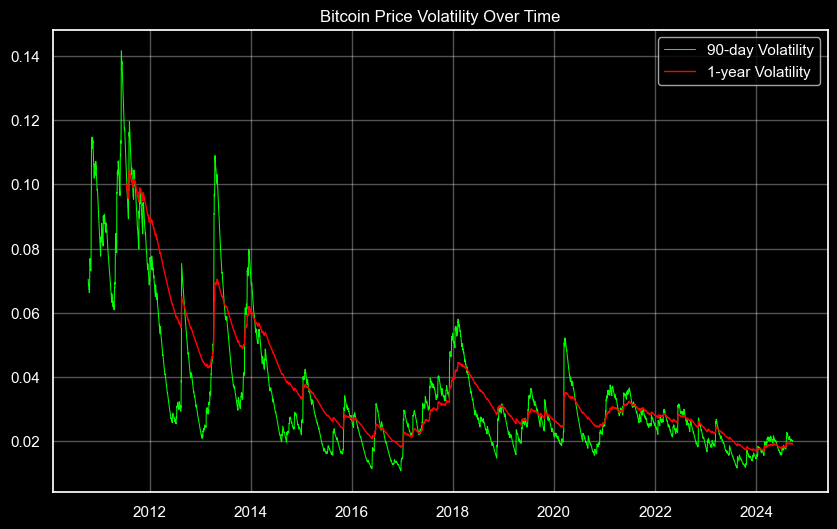

In [8]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_btc, x=df_btc.index, y="volatility_90d", label="90-day Volatility", color="#00ff01", linewidth=0.75)
sns.lineplot(data=df_btc, x=df_btc.index, y="volatility_1y", label="1-year Volatility", color="#ff0007", linewidth=1)

plt.title("Bitcoin Price Volatility Over Time")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("3.1_BTC_vlt")

In [9]:
# All-time high 1-year volatility
ath_date = df_btc["volatility_1y"].idxmax()
df_btc.loc[[ath_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
2011-08-09,9.99,0.104845


In [10]:
# All-time low 1-year volatility
atl_date = df_btc["volatility_1y"].idxmin()
df_btc.loc[[atl_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
2023-12-31,42294.65,0.016885


In [11]:
# Top 5 peaks of 1-year volatility
peaks, _ = signal.find_peaks(df_btc["volatility_1y"], distance=500)
df_btc.iloc[peaks].nlargest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,2011-08-09,2013-05-03,2014-09-19,2018-02-07,2020-03-24
volatility_1y,0.104845,0.070397,0.038608,0.044474,0.035102


In [12]:
# Top 5 valleys of 1-year volatility
valleys, _ = signal.find_peaks(-df_btc["volatility_1y"], distance=500)
df_btc.iloc[valleys].nsmallest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,2016-12-20,2019-05-08,2020-11-04,2022-06-10,2023-12-31
volatility_1y,0.018016,0.025224,0.024266,0.025753,0.016885


In [13]:
# Average 1-year volatility
df_btc["volatility_1y"].mean().round(3)

0.036

**Key takeaways:**
- The five biggest daily price changes occurred in 2010 and 2011, marking bitcoin’s early years as a period of intense volatility.
- From 2010 until early 2017, average volatility decreased by about 80%, reflecting the market’s maturation. However, it still experiences occasional spikes.
- After the 2017 spike, bitcoin resumed its downward trend in 2018.
- In recent years, bitcoin has become consistently more stable.
- The decrease in volatility over time is closely linked to the factors already mentioned like a larger market cap, increased liquidity, and also institutional involvement.
- This curve highlights bitcoin's evolution from a speculative asset to a more established component of the global financial system.

### Comparison of Volatility With Other Assets

In [14]:
# Resample all dfs to weekly frequency, to be able to compare with bitcoin's 365 trading days, and also make sure other dfs start at the same point of btc df.
df_btc_w = df_btc[["price"]].resample("W").mean()
df_sp500_w = df_sp500.loc[df_sp500.index >= df_btc.index.min()].resample("W").mean()
df_us10y_w = df_us10y.loc[df_us10y.index >= df_btc.index.min()].resample("W").mean()
df_au_w = df_au.loc[df_au.index >= df_btc.index.min()].resample("W").mean()
df_wti_w = df_wti.loc[df_wti.index >= df_btc.index.min()].resample("W").mean()
df_chf_w = df_chf.loc[df_chf.index >= df_btc.index.min()].resample("W").mean()

In [15]:
# Get 1-year volatility for each weekly df
for df in [df_btc_w, df_sp500_w, df_us10y_w, df_wti_w, df_au_w, df_chf_w]:
    # Replace non-positive values with NaN to avoid issues in log calculation (only the oil df has non-positive prices)
    df.iloc[:, 0] = df.iloc[:, 0].where(df.iloc[:, 0] > 0, np.nan)
    # Get log returns based on first column
    df["log_returns"] = np.log(df.iloc[:, 0] / df.iloc[:, 0].shift(1))
    # Get 1-year volatility with the exponentially weighted moving average (EWMA) method
    df["volatility_1y"] = df["log_returns"].ewm(span=52).std()
    # Remove first cycle to avoid having unreliable volatility measures
    df.drop(index=df.index[:51], inplace=True)

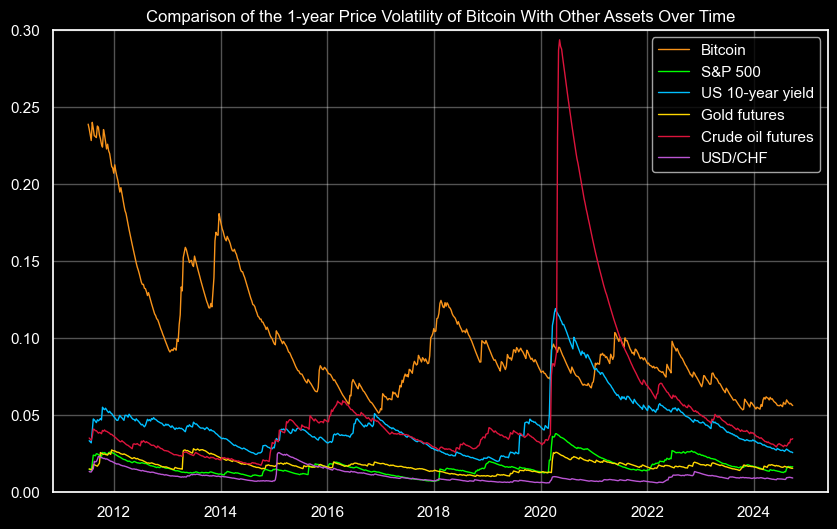

In [16]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_btc_w, x=df_btc_w.index, y="volatility_1y", label="Bitcoin", color="#f7931a", linewidth=1)
sns.lineplot(data=df_sp500_w, x=df_sp500_w.index, y="volatility_1y", label="S&P 500", color="lime", linewidth=1)
sns.lineplot(data=df_us10y_w, x=df_us10y_w.index, y="volatility_1y", label="US 10-year yield", color="deepskyblue", linewidth=1)
sns.lineplot(data=df_au_w, x=df_au_w.index, y="volatility_1y", label="Gold futures", color="gold", linewidth=1)
sns.lineplot(data=df_wti_w, x=df_wti_w.index, y="volatility_1y", label="Crude oil futures", color="crimson", linewidth=1)
sns.lineplot(data=df_chf_w, x=df_chf_w.index, y="volatility_1y", label="USD/CHF", color="mediumorchid", linewidth=1)

plt.ylim([0, 0.3])

plt.title("Comparison of the 1-year Price Volatility of Bitcoin With Other Assets Over Time")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("3.1_BTC_vlt_comparison")

In [17]:
# Create table with average 1-year volatility of each asset for different timeframes
def get_timeframes_avg_vlt(df: pd.DataFrame) -> dict[str, float]:
    return {
        "Total avg volatility": round(df["volatility_1y"].mean(), 4),
        "2011-2016 avg": round(df[df.index.year < 2016]["volatility_1y"].mean(), 4),
        "2016-2020 avg": round(df[(df.index.year >= 2016) & (df.index.year < 2020)]["volatility_1y"].mean(), 4),
        "2020-2024 avg": round(df[df.index.year >= 2020]["volatility_1y"].mean(), 4),
    }

df_avg_vlt = pd.DataFrame({
    "Bitcoin": get_timeframes_avg_vlt(df_btc_w),
    "S&P 500": get_timeframes_avg_vlt(df_sp500_w),
    "US 10-year yield": get_timeframes_avg_vlt(df_us10y_w),
    "Gold futures": get_timeframes_avg_vlt(df_au_w),
    "Crude oil futures": get_timeframes_avg_vlt(df_wti_w),
    "USD/CHF": get_timeframes_avg_vlt(df_chf_w),
}).T

df_avg_vlt.sort_values(by=df_avg_vlt.columns[0], ascending=False)

,Total avg volatility,2011-2016 avg,2016-2020 avg,2020-2024 avg
Bitcoin,0.0981,0.1352,0.0832,0.0756
Crude oil futures,0.0525,0.0303,0.0384,0.0852
US 10-year yield,0.0434,0.0394,0.0330,0.0560
Gold futures,0.0173,0.0198,0.0143,0.0176
S&P 500,0.0167,0.0154,0.0136,0.0205
USD/CHF,0.0104,0.0137,0.0089,0.0085


**Key takeaways:**
- Before 2016, bitcoin's volatility was significantly higher than that of other major assets.
- In 2016, its volatility approached that of crude oil and US 10-year bonds, but they diverged again until 2020.
- When the pandemic hit, volatility spiked across all assets, with bitcoin's increase being relatively ordinary compared to others.
- Crude oil experienced an enormous volatility spike during this period, while US 10-year bonds also saw a substantial increase, both surpassing bitcoin's volatility for that year.
- In recent years, the cryptocurrency continues to lead in volatility, though it is now much closer to other volatile assets like crude oil.

## Bitcoin Yearly Volatility Over Time 📊

In [18]:
# Group by year and get standard deviation of price change along with the number of days
df_btc_yearly = df_btc.groupby(df_btc.index.year).agg(
    volatility=("price_change_log", "std"),
    num_days=("price_change_log", "count"),
)

In [19]:
# Annualize the volatility for incomplete years (2010 and 2024), multiplying by the square root of the division of 365 by number of days
df_btc_yearly.loc[df_btc_yearly["num_days"] < 365, "volatility"] *= (365 / df_btc_yearly["num_days"])**0.5

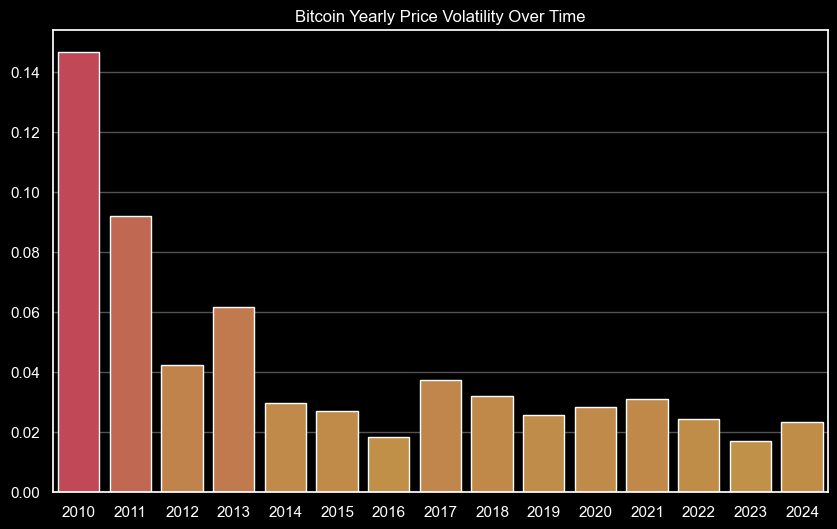

In [20]:
plt.figure(figsize=(10, 6))

palette_reds = mpl_cols.LinearSegmentedColormap.from_list("volatility", ["#d49534", "#d43448"])

sns.barplot(data=df_btc_yearly, x=df_btc_yearly.index, y="volatility", palette=palette_reds, hue="volatility", legend=False)

plt.title("Bitcoin Yearly Price Volatility Over Time")
plt.xlabel(None)
plt.ylabel(None)

save_chart_as_png("3.1_BTC_yearly_vlt")

In [21]:
# Create table with yearly volatility stats
pd.DataFrame({
    "Average yearly volatility": [round(df_btc_yearly["volatility"].mean(), 4)],
    "Median yearly volatility": [round(df_btc_yearly["volatility"].median(), 4)],
    "Standard deviation": [round(df_btc_yearly["volatility"].std(), 4)],
    "Min yearly volatility": [round(df_btc_yearly["volatility"].min(), 4)],
    "Max yearly volatility": [round(df_btc_yearly["volatility"].max(), 4)],
})

,Average yearly volatility,Median yearly volatility,Standard deviation,Min yearly volatility,Max yearly volatility
0,0.0424,0.0295,0.0346,0.0168,0.1467


**Key takeaways:**
- The first four years were the most speculative, marking bitcoin's experimental phase.
- From 2014 onward, volatility began to stabilize, with noticeable spikes during rallies and crashes.
- Since 2017, there has been a clear downtrend in volatility, reflecting gradual maturity of this asset, as seen in the line chart before.
- The most volatile year was 2010, while 2023 was the least volatile.
- Volatility data for 2010 and 2024 are estimates, as these years are incomplete and were annualized.

## Price vs. Volatility 📉

In [22]:
# Get 90-day moving average price
df_btc["price_90d_ma"] = df_btc["price"].rolling(window=90).mean()

In [23]:
# Get 90-day rolling volatility with the standard deviation method
df_btc["volatility_90d_mstd"] = df_btc["price_change_log"].rolling(window=90).std()

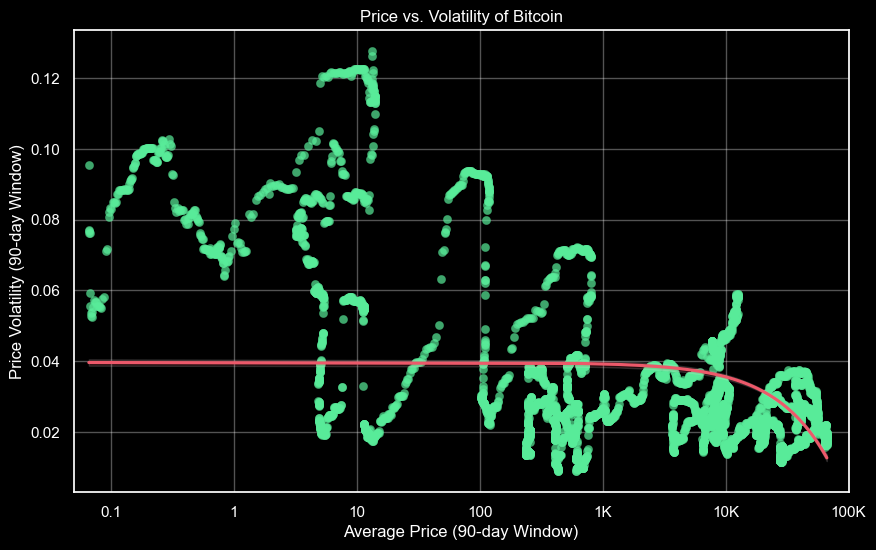

In [24]:
plt.figure(figsize=(10, 6))

sns.regplot(data=df_btc, x="price_90d_ma", y="volatility_90d_mstd",
            scatter_kws={"alpha": 0.7, "linewidths": 0.2, "color": "#59ec9a"},
            line_kws={"color": "#ec596a"})

plt.xscale("log")
plt.xlim(0.05, 100_000)

plt.gca().xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if x < 1000 and x.is_integer()
                  else (f"{x:.1f}" if x < 1 else f"{int(x/1000)}K"))
)

plt.title("Price vs. Volatility of Bitcoin")
plt.xlabel("Average Price (90-day Window)")
plt.ylabel("Price Volatility (90-day Window)")

save_chart_as_png("3.1_BTC_price_vs_vlt")

In [25]:
# Pearson correlation coefficient betweent price and volatility
df_btc["price_90d_ma"].corr(df_btc["volatility_90d_mstd"]).round(2)

-0.31

**Key takeaways:**
- Comparing price with volatility reveals a shift in the landscape, as anticipated.
- As the price (or market cap) rises, volatility tends to decrease.
- This trend becomes particularly noticeable after the price surpasses one thousand, and especially after it exceeds ten thousand, where volatility remains contained below 0.04.
- The correlation between price and volatility is moderately negative at -0.31.

## Volatility vs. Returns 💸

In [26]:
# Get daily logarithmic price change and 90-day moving average
df_btc["price_change_log"] = np.log(df_btc["price"] / df_btc["price"].shift(1))
df_btc["price_change_log_90d_ma"] = df_btc["price_change_log"].rolling(window=90).mean()

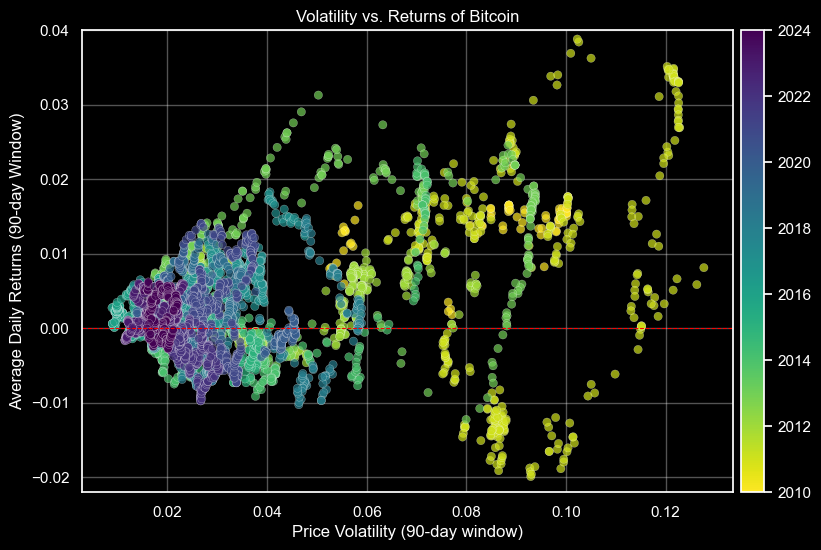

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

# Normalize years to map colors
norm = mpl_cols.Normalize(vmin=df_btc.index.year.min(), vmax=df_btc.index.year.max())
cmap = plt.cm.viridis_r

sns.scatterplot(data=df_btc, x="volatility_90d_mstd", y="price_change_log_90d_ma", hue=df_btc.index.year, palette=cmap, alpha=0.7, linewidth=0.2, legend=False)

plt.axhline(y=0, color="red", linewidth=3/4, linestyle="--")

plt.ylim(-0.022, 0.04)

plt.title("Volatility vs. Returns of Bitcoin")
plt.xlabel("Price Volatility (90-day window)")
plt.ylabel("Average Daily Returns (90-day Window)")

# Create the colorbar
cax, _ = mpl_cbar.make_axes(ax, location="right", pad=0.01)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cax)

save_chart_as_png("3.1_BTC_vlt_vs_returns")

In [28]:
# Pearson correlation coefficient betweent volatility and returns
df_btc["volatility_90d_mstd"].corr(df_btc["price_change_log_90d_ma"]).round(2)

0.4

**Key takeaways:**
- Comparing returns with volatility creates an engaging chart that illustrates the maturation of the asset over the years.
- During the experimental phase, we observe distinct periods characterized by both high positive and negative returns.
- As the years progress, particularly after 2019, volatility significantly decreases, along with absolute returns, resulting in a concentrated cluster that tightens with more recent data.
- In periods of high volatility, we often see that returns are predominantly positive, as supported by a moderate correlation between volatility and returns of 0.4.

### Comparison of Volatility vs. Returns With Other Assets

In [29]:
# Get arithmetic returns for each df, instead of log returns since the oil data includes non-positive prices
for df in [df_btc, df_sp500, df_us10y, df_wti, df_au, df_chf]:
    df["returns"] = df.iloc[:, 0].pct_change()

In [30]:
# Get df with average returns and std deviation of returns from all dfs since first data point of btc df
dfs = {
    "Bitcoin": df_btc,
    "S&P 500": df_sp500,
    "US 10-year yield": df_us10y,
    "Gold futures": df_au,
    "Crude oil futures": df_wti,
    "USD/CHF": df_chf,
}
results = []
for asset, df in dfs.items():
    results.append({"asset": asset,
                    "returns_avg": df.loc[df.index >= df_btc.index.min()]["returns"].mean(),
                    "returns_std": df.loc[df.index >= df_btc.index.min()]["returns"].std(),
                   })

df_comparison = pd.DataFrame(results)
df_comparison

,asset,returns_avg,returns_std
0,Bitcoin,0.003660,0.044084
1,S&P 500,0.000498,0.007966
2,US 10-year yield,0.000376,0.024974
3,Gold futures,0.000251,0.007840
4,Crude oil futures,-0.002861,0.150931
5,USD/CHF,-0.000044,0.005084


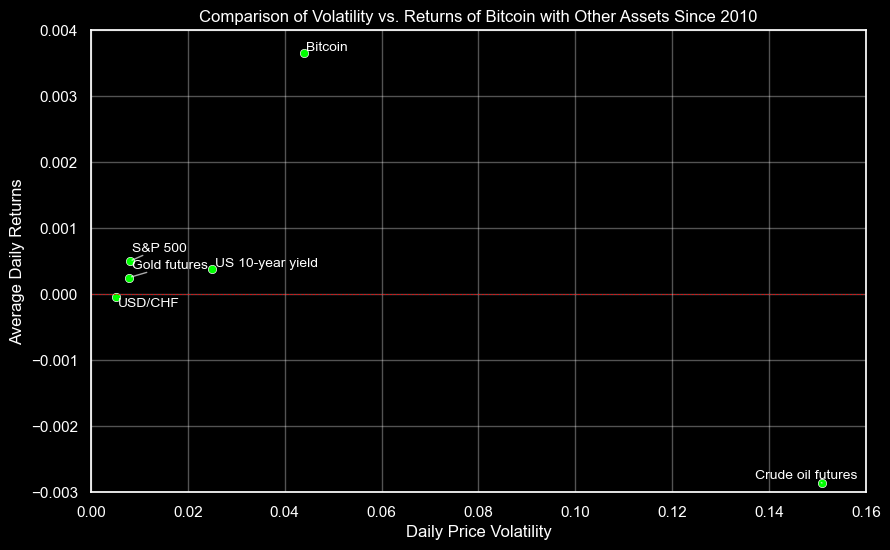

In [31]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_comparison, x="returns_std", y="returns_avg", color="lime")

plt.axhline(y=0, color="red", linewidth=1/2, linestyle="--")

plt.xlim(0, 0.16)
plt.ylim(-0.003, 0.004)

# Add labels to each point
texts = []
for i, row in df_comparison.iterrows():
    texts.append(plt.text(row["returns_std"], row["returns_avg"], row["asset"], fontsize=10))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="white", alpha=2/3))

plt.title("Comparison of Volatility vs. Returns of Bitcoin with Other Assets Since 2010")
plt.xlabel("Daily Price Volatility")
plt.ylabel("Average Daily Returns")

save_chart_as_png("3.1_BTC_vlt_vs_returns_comparison")

**Key takeaways:**
- This chart illustrates the comparison of major assets concerning their volatility and returns since 2010.
- A notable cluster appears for all assets, except for crude oil and bitcoin.
- The cryptocurrency showcases significantly higher returns, but this comes with much greater volatility. In this case, it paid off the bet on risk.
- The impact of the 2020 situation positions crude oil poorly within this chart.